In [14]:
# import das bibliotecas
import pyspark
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import collections
import os
from os.path import isfile, isdir, join
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
import psycopg2

In [3]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars file:///home/jovyan/jdbc/postgresql-42.2.17.jar pyspark-shell'

In [21]:
db_url = "jdbc:postgresql://postgres:5432/dbinovacnj"
db_name = "dbinovacnj"
db_user = "inovacnj"
db_pass = "inovacnj@admin"
db_driver = "org.postgresql.Driver"

In [27]:
# inicialização do spark
conf = SparkConf() \
        .setMaster("local[2]") \
        .setAppName("LendoDB") \
        .set("spark.executor.memory", "4g") \
        .set("spark.driver.memory", "4g") \
        .set("spark.driver.maxResultSize", "2g") \
        .set("spark.ui.enabled", "true") \
        .set("spark.sql.shuffle.partitions" , "800") \
        .set("spark.sql.execution.arrow.pyspark.enabled" , "false") \

spark = SparkSession \
    .builder \
    .config(conf=conf) \
    .getOrCreate()

sc = spark.sparkContext

In [28]:
# definindo o schema dos dados
schema = StructType([
    StructField("dadosBasicos", StructType([
        StructField("assunto", ArrayType(
            StructType([
                StructField("assuntoLocal", StructType([
                    StructField("codigoAssunto", LongType(), True),
                    StructField("codigoPaiNacional", LongType(), True),
                    StructField("descricao", StringType(), True)
                ]), True),
                StructField("codigoNacional", LongType(), True),
                StructField("principal", BooleanType(), True)
            ]),
        ), True),
        StructField('classeProcessual', LongType(), True),
        StructField('codigoLocalidade', StringType(), True),
        StructField('competencia', StringType(), True),
        StructField('dataAjuizamento', StringType(), True),
        StructField('dscSistema', StringType(), True),
        StructField('nivelSigilo', LongType(), True),
        StructField('numero', StringType(), True),
        StructField("orgaoJulgador", StructType([
            StructField("codigoMunicipioIBGE", LongType(), True),
            StructField("codigoOrgao", StringType(), True),
            StructField("instancia", StringType(), True),
            StructField("nomeOrgao", StringType(), True)
        ]), True),
        StructField('procEl', LongType(), True),
        StructField("tamanhoProcesso", StringType(), True),
        StructField("totalAssuntos", LongType(), True),
        StructField("valorCausa", StringType(), True)       
    ]), True),
    StructField("grau", StringType(), True),
    StructField("millisInsercao", LongType(), True),
    StructField("movimento", ArrayType(     
        StructType([
            StructField("complementoNacional", ArrayType(
                StructType([
                    StructField("codComplemento", LongType(), True),
                    StructField("codComplementoTabelado", LongType(), True),
                    StructField("descricaoComplemento", StringType(), True),
                ])
            ), True),
            StructField("dataHora", StringType(), True),
            StructField("idDocumentoVinculado", ArrayType(
                StringType(),
            ), True),
            StructField("identificadorMovimento", StringType(), True),
            StructField("movimentoLocal", StructType([
                StructField('codigoMovimento', LongType(), True),
                StructField('codigoPaiNacional', LongType(), True)
            ]), True),
            StructField("movimentoNacional", StructType([
                StructField('codigoNacional', LongType(), True)
            ]), True),
            StructField("nivelSigilo", StringType(), True),
            StructField("orgaoJulgador", StructType([
                StructField("codigoMunicipioIBGE", LongType(), True),
                StructField("codigoOrgao", StringType(), True),
                StructField("instancia", StringType(), True),
                StructField("nomeOrgao", StringType(), True)
            ]), True),
            StructField("tipoDecisao", StringType(), True),
            StructField("tipoResponsavelMovimento", StringType(), True)
        ]),
    ), True),
    StructField("siglaTribunal", StringType(), True)
])

In [29]:
# carrega do dataframe de classes
df_classes = spark.read \
    .option("header","true") \
    .option("inferSchema","true") \
    .option("delimiter",";") \
    .csv("./base/sgt_classes.csv")

df_classes.createOrReplaceTempView("classes")
   
df_qry_classes = spark.sql(
    "SELECT " +
    "codigo AS cod," + 
    "descricao," + 
    "sigla," + 
    "cod_pai AS codpai " +    
    "FROM classes "
)

df_qry_classes.write \
    .mode("overwrite") \
    .format("jdbc") \
    .option("url", db_url).option("user", db_user).option("password", db_pass).option("driver", db_driver) \
    .option("dbtable", "inovacnj.classe") \
    .save()

print("tabela inovacnj.classe criada.")

tabela inovacnj.classe criada.


In [30]:
# carrega do dataframe de assuntos
df_assuntos = spark.read \
    .option("header","true") \
    .option("inferSchema","true") \
    .option("delimiter",";") \
    .csv("./base/sgt_assuntos.csv")

df_assuntos.createOrReplaceTempView("assuntos")
   
df_qry_assuntos = spark.sql(
    "SELECT " +
    "codigo AS cod," + 
    "descricao," + 
    "cod_pai AS codpai " +    
    "FROM assuntos "
)

df_qry_assuntos.write \
    .mode("overwrite") \
    .format("jdbc") \
    .option("url", db_url).option("user", db_user).option("password", db_pass).option("driver", db_driver) \
    .option("dbtable", "inovacnj.assunto") \
    .save()

print("tabela inovacnj.assunto criada.")

tabela inovacnj.assunto criada.


In [31]:
# carrega o dataframe de movimentos
df_movimentos = spark.read \
    .option("header","true") \
    .option("inferSchema","true") \
    .option("delimiter",";") \
    .csv("./base/sgt_movimentos.csv")

# cria uma view temporaria dos movimentos
df_movimentos.createOrReplaceTempView("movimentos")

# carrega o dataframe de movimentos nacionais (com nossa classificacao de fases e natureza)
df_movimentosNac = spark.read \
    .option("header","true") \
    .option("inferSchema","true") \
    .option("delimiter",";") \
    .csv("./base/MovimentosNacionais.csv")

df_movimentosNac.createOrReplaceTempView("movimentos_nac")

df_qry_movimentosNac = spark.sql(
    "SELECT " +
    "trim(substring_index(MOVIMENTO, '-', 1)) AS codmovimento, " + 
    "trim(substring_index(MOVIMENTO, '-', -1)) AS descmovimento, " + 
    "CASE WHEN NATUREZA IS NULL THEN 'GERAL' ELSE NATUREZA END AS natureza, " +
    "CASE WHEN FASE IS NULL THEN 'F0 - NÃO CLASSIFICADO' ELSE FASE END AS fase " +
    "FROM movimentos_nac " +
    "WHERE RELEVANCIA = 1"
)

df_movimentos_join = df_movimentos \
    .join(df_qry_movimentosNac, df_movimentos["codigo"] == df_qry_movimentosNac["codmovimento"], "left")

df_movimentos_join.createOrReplaceTempView("movimentos_com_fase")

df_qry_movimentos = spark.sql(
    "SELECT " +
    "codigo AS cod," + 
    "descricao," + 
    "natureza, " +
    "fase, " +
    "cod_pai AS codpai " +    
    "FROM movimentos_com_fase "
)

df_qry_movimentos.write \
    .mode("overwrite") \
    .format("jdbc") \
    .option("url", db_url).option("user", db_user).option("password", db_pass).option("driver", db_driver) \
    .option("dbtable", "inovacnj.movimentocnj") \
    .save()

print("tabela inovacnj.movimentocnj criada.")

tabela inovacnj.movimentocnj criada.


In [32]:
# carrega do dataframe de serventias
df_serventias = spark.read \
    .option("header","true") \
    .option("inferSchema","true") \
    .option("delimiter",";") \
    .csv("./base/mpm_serventias.csv")

df_serventias.createOrReplaceTempView("serventias")

df_qry_serventias = spark.sql(
    "SELECT " +
    "SEQ_ORGAO AS cod, " + 
    "DSC_ORGAO AS descricao, " + 
    "SEQ_ORGAO_PAI AS codpai, " + 
    "TIP_ORGAO AS sigla_tipoj, " + 
    "DSC_TIP_ORGAO AS tipo_oj, " + 
    "DSC_CIDADE AS cidade, " + 
    "SIG_UF AS uf, " + 
    "COD_IBGE AS codibge, " + 
    "TIP_ESFERA_JUSTICA AS esfera " + 
    "FROM serventias "
)

df_qry_serventias.write \
    .mode("overwrite") \
    .format("jdbc") \
    .option("url", db_url).option("user", db_user).option("password", db_pass).option("driver", db_driver) \
    .option("dbtable", "inovacnj.orgao_julgador") \
    .save()

print("tabela inovacnj.orgao_julgador criada.")

tabela inovacnj.orgao_julgador criada.


In [33]:
# carregamento de todos os arquivos em um único DataFrame e geracao do CSV
basedir = "./base"

dirs_ramos_justica = [join(basedir, f) for f in os.listdir(basedir) if isdir(join(basedir, f))]

is_first = True

for dir_ramo_just in dirs_ramos_justica:
    print("Iniciando carregamento do ramo de justica: " + dir_ramo_just)
    dirs_tribunais = [join(dir_ramo_just, f) for f in os.listdir(dir_ramo_just) if isdir(join(dir_ramo_just, f))]
    
    for dir_trib in dirs_tribunais:
        print("Iniciando carregamento do tribunal: " + dir_trib)
        
        arquivos = [join(dir_trib, f) for f in os.listdir(dir_trib) if isfile(join(dir_trib, f))]
        
        df_union_tribunal = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)
        
        for arq in arquivos:
            if arq.endswith(".DS_Store") :
                continue
                
            print("Carregando dataframe do arquivo: " + arq)
            df = spark.read.schema(schema).json(arq)
            df_union_tribunal = df_union_tribunal.union(df)
        
        # Cria uma view temporaria para o dataframe
        df_union_tribunal.createOrReplaceTempView("proc_movimentos")
        
        # Query para formato em CSV
        df_query_distinct = spark.sql(
            "SELECT DISTINCT " + 
            "siglaTribunal AS codtribunal, " + 
            "grau, " +
            "millisinsercao, " +

            "dadosBasicos.classeProcessual AS codclasse, " +
            "dadosBasicos.codigoLocalidade AS codlocalidade, " +
            "dadosBasicos.competencia, " +
            "to_timestamp(dadosBasicos.dataAjuizamento, 'yyyyMMddHHmmss') AS dtajuizamento, "
            "dadosBasicos.dscSistema AS descsistema, " +
            "dadosBasicos.nivelSigilo AS nivelsigilo, " +
            "dadosBasicos.numero AS npu, " + 
            "dadosBasicos.orgaoJulgador.codigoMunicipioIBGE AS oj_codibge, " +
            "dadosBasicos.orgaoJulgador.codigoOrgao AS oj_cod, " +
            "dadosBasicos.orgaoJulgador.instancia AS oj_instancia, " +
            "dadosBasicos.orgaoJulgador.nomeOrgao AS oj_descricao, " +
            "dadosBasicos.procEl AS tramitacao, " +
            "dadosBasicos.tamanhoProcesso AS tamanhoprocesso, " +
            "dadosBasicos.valorCausa AS valorcausa, " +

            "exp_assunto.assunto.codigoNacional AS ass_cod, " +
            "exp_assunto.assunto.principal AS ass_principal, " + 
            "exp_assunto.assunto.assuntoLocal.codigoAssunto AS ass_codlocal, " +
            "exp_assunto.assunto.assuntoLocal.codigoPaiNacional AS ass_codpainacional, " +
            "exp_assunto.assunto.assuntoLocal.descricao AS ass_desclocal, " +

            "to_timestamp(exp_movimento.movimento.dataHora, 'yyyyMMddHHmmss') AS mov_dtmov, " +
            "exp_movimento.movimento.movimentoLocal.codigoMovimento AS mov_codlocal, " +
            "exp_movimento.movimento.movimentoLocal.codigoPaiNacional AS mov_codpainacional, " +
            "exp_movimento.movimento.movimentoNacional.codigoNacional AS mov_cod, " +
            "exp_movimento.movimento.nivelSigilo AS mov_nivelsigilo, " +

            "exp_movimento.movimento.orgaoJulgador.codigoMunicipioIBGE as mov_oj_codibge, " +
            "exp_movimento.movimento.orgaoJulgador.codigoOrgao as mov_oj_cod, " +
            "exp_movimento.movimento.orgaoJulgador.instancia as mov_oj_instancia, " +
            "exp_movimento.movimento.orgaoJulgador.nomeOrgao as mov_oj_descricao, " +

            "exp_movimento.movimento.tipoDecisao as mov_tpdecisao, " +
            "exp_movimento.movimento.tipoResponsavelMovimento as mov_tprespmov " +

            "FROM proc_movimentos " + 
            "LATERAL VIEW explode(dadosBasicos.assunto) exp_assunto as assunto " +
            "LATERAL VIEW explode(movimento) exp_movimento as movimento " + 
            "WHERE to_timestamp(dadosBasicos.dataAjuizamento, 'yyyyMMddHHmmss') >= to_timestamp('20000101000000', 'yyyyMMddHHmmss') " + 
            "AND exp_movimento.movimento.movimentoNacional.codigoNacional NOT IN(581, 85, 12270, 12271) " + 
            "AND size(proc_movimentos.movimento) > 0 "
            "AND (proc_movimentos.movimento[0].movimentoNacional.codigoNacional IN (26, 12474) " +
            "AND proc_movimentos.movimento[size(proc_movimentos.movimento) -1].movimentoNacional.codigoNacional IN (22, 246)) "
        )
        
        df_movimentos_join = df_query_distinct \
           .join(df_qry_movimentosNac, df_query_distinct["mov_cod"] == df_qry_movimentosNac["codmovimento"], "left") \
           .select( \
                col("codtribunal"), col("grau"), col("millisinsercao"), col("codclasse"), \
                col("codlocalidade"), col("competencia"), col("dtajuizamento"), col("descsistema"), \
                col("nivelsigilo"), col("npu"), col("oj_codibge"), col("oj_cod"), \
                col("oj_instancia"), col("oj_descricao"), col("tramitacao"), col("tamanhoprocesso"), \
                col("valorcausa"), col("ass_cod"), col("ass_principal"), col("ass_codlocal"), \
                col("ass_codpainacional"), col("ass_desclocal"), col("mov_dtmov"), col("mov_codlocal"), \
                col("mov_codpainacional"), col("mov_cod"), col("mov_nivelsigilo"), col("mov_oj_codibge"), \
                col("mov_oj_cod"), col("mov_oj_instancia"), col("mov_oj_descricao"), col("mov_tpdecisao"), \
                col("mov_tprespmov"), col("natureza"), col("fase") \
        )
        
        df_query_distinctPd = df_movimentos_join.toPandas()
        df_query_distinctPd.to_csv('./output/movimentos_tribunais.csv', mode='a', header=is_first, sep = ";", index=False, chunksize=1000)
        
        if is_first == True:
            is_first = False
            df_movimentos_join.repartition(5).write \
                .mode("overwrite") \
                .format("jdbc") \
                .option("url", db_url).option("user", db_user).option("password", db_pass).option("driver", db_driver) \
                .option("dbtable", "inovacnj.fat_movimentos_te") \
                .option("batchsize", "10000") \
                .save()
        else :
            df_movimentos_join.repartition(5).write \
                .mode("append") \
                .format("jdbc") \
                .option("url", db_url).option("user", db_user).option("password", db_pass).option("driver", db_driver) \
                .option("dbtable", "inovacnj.fat_movimentos_te") \
                .option("batchsize", "10000") \
                .save()

        print("Finalizando carregamento do tribunal: " + dir_trib)
        
    print("Finalizando carregamento do ramo de justica: " + dir_ramo_just)
    
print("Carregamento dos arquivos finalizado.")


Iniciando carregamento do ramo de justica: ./base/justica_estadual
Iniciando carregamento do tribunal: ./base/justica_estadual/processos-tjba
Carregando dataframe do arquivo: ./base/justica_estadual/processos-tjba/.DS_Store
Carregando dataframe do arquivo: ./base/justica_estadual/processos-tjba/processos-tjba_11.json
Finalizando carregamento do tribunal: ./base/justica_estadual/processos-tjba
Iniciando carregamento do tribunal: ./base/justica_estadual/processos-tjpa
Carregando dataframe do arquivo: ./base/justica_estadual/processos-tjpa/.DS_Store
Carregando dataframe do arquivo: ./base/justica_estadual/processos-tjpa/processos-tjpa_11.json
Finalizando carregamento do tribunal: ./base/justica_estadual/processos-tjpa
Iniciando carregamento do tribunal: ./base/justica_estadual/processos-tjpr
Carregando dataframe do arquivo: ./base/justica_estadual/processos-tjpr/.DS_Store
Carregando dataframe do arquivo: ./base/justica_estadual/processos-tjpr/processos-tjpr_11.json
Finalizando carregament

Finalizando carregamento do tribunal: ./base/justica_estadual/processos-tjsp
Iniciando carregamento do tribunal: ./base/justica_estadual/processos-tjrs
Carregando dataframe do arquivo: ./base/justica_estadual/processos-tjrs/.DS_Store
Carregando dataframe do arquivo: ./base/justica_estadual/processos-tjrs/processos-tjrs_10.json
Finalizando carregamento do tribunal: ./base/justica_estadual/processos-tjrs
Iniciando carregamento do tribunal: ./base/justica_estadual/processos-tjro
Carregando dataframe do arquivo: ./base/justica_estadual/processos-tjro/.DS_Store
Carregando dataframe do arquivo: ./base/justica_estadual/processos-tjro/processos-tjro_11.json
Finalizando carregamento do tribunal: ./base/justica_estadual/processos-tjro
Iniciando carregamento do tribunal: ./base/justica_estadual/processos-tjrr
Carregando dataframe do arquivo: ./base/justica_estadual/processos-tjrr/.DS_Store
Carregando dataframe do arquivo: ./base/justica_estadual/processos-tjrr/processos-tjrr_11.json
Finalizando c

In [64]:
# carrega do dataframe com todos os movimentos dos processos
df_proc_movimentos = spark.read \
    .option("header","true") \
    .option("inferSchema","true") \
    .option("delimiter",";") \
    .csv("./output/movimentos.csv")

# Cria uma view temporaria para o dataframe
df_proc_movimentos.createOrReplaceTempView("temp_proc_movimentos")
df_proc_movimentos.printSchema()
df_proc_movimentos.show(1, False)

root
 |-- codtribunal: string (nullable = true)
 |-- grau: string (nullable = true)
 |-- millisinsercao: long (nullable = true)
 |-- codclasse: integer (nullable = true)
 |-- codlocalidade: integer (nullable = true)
 |-- competencia: string (nullable = true)
 |-- dtajuizamento: string (nullable = true)
 |-- descsistema: integer (nullable = true)
 |-- nivelsigilo: integer (nullable = true)
 |-- npu: long (nullable = true)
 |-- oj_codibge: integer (nullable = true)
 |-- oj_cod: integer (nullable = true)
 |-- oj_instancia: string (nullable = true)
 |-- oj_descricao: string (nullable = true)
 |-- tramitacao: integer (nullable = true)
 |-- tamanhoprocesso: string (nullable = true)
 |-- valorcausa: string (nullable = true)
 |-- ass_cod: integer (nullable = true)
 |-- ass_principal: boolean (nullable = true)
 |-- ass_codlocal: string (nullable = true)
 |-- ass_codpainacional: string (nullable = true)
 |-- ass_desclocal: string (nullable = true)
 |-- mov_dtmov: string (nullable = true)
 |-- mo

In [71]:
def gerar_modelo_pm_from_df(df, codtribunal, grau, natureza, codclasse):
    
    df.createOrReplaceTempView("temp_df_modelo_pm")
    
    sql = "SELECT npu, fase, to_timestamp(mov_dtmov, 'yyyy-MM-dd HH:mm:ss') as dtmov "
    sql+= "FROM temp_df_modelo_pm "
    sql+= "WHERE (1=1) "
    if codtribunal != None :
        sql+= "AND codtribunal = '" + codtribunal + "' "
    if grau != None :
        sql+= "AND grau = '" + grau + "' "
    if natureza != None :
        sql+= "AND natureza = '" + natureza + "' "
    if codclasse != None :
        sql+= "AND codclasse = " + str(codclasse) + " "
        
    sql+= "ORDER BY dtmov ASC "
    
    df_logeventos = spark.sql(sql)
    
    df_logeventos_pd = df_logeventos.toPandas()
    dataframe = pm4py.format_dataframe(df_logeventos_pd, case_id='npu', activity_key='fase', timestamp_key='dtmov')
    eventLog = pm4py.convert_to_event_log(dataframe)

    dfg = dfg_discovery.apply(eventLog, variant=dfg_discovery.Variants.PERFORMANCE)
    gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.PERFORMANCE)
    #dfg_visualization.view(gviz)
    
    return gviz

In [76]:
def gerar_modelo_pm_from_db(codtribunal, grau, natureza, codclasse):
    
    sql = "SELECT npu, fase, mov_dtmov "
    sql+= "FROM inovacnj.fat_movimentos_tjpe "
    sql+= "WHERE (1=1) "
    if codtribunal != None :
        sql+= "AND codtribunal = '" + codtribunal + "' "
    if grau != None :
        sql+= "AND grau = '" + grau + "' "
    if natureza != None :
        sql+= "AND natureza = '" + natureza + "' "
    if codclasse != None :
        sql+= "AND codclasse = " + str(codclasse) + " "
        
    sql+= "ORDER BY mov_dtmov ASC "
    
    df_logeventos = spark.read \
        .format("jdbc") \
        .option("url", "jdbc:postgresql://postgres:5432/dbinovacnj") \
        .option("query", sql) \
        .option("user", "inovacnj") \
        .option("password", "inovacnj@admin") \
        .option("driver", "org.postgresql.Driver") \
        .load()
    
    df_logeventos_pd = df_logeventos.toPandas()
    dataframe = pm4py.format_dataframe(df_logeventos_pd, case_id='npu', activity_key='fase', timestamp_key='mov_dtmov')
    eventLog = pm4py.convert_to_event_log(dataframe)

    dfg = dfg_discovery.apply(eventLog, variant=dfg_discovery.Variants.PERFORMANCE)
    gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.PERFORMANCE)
    #dfg_visualization.view(gviz)
    
    return gviz

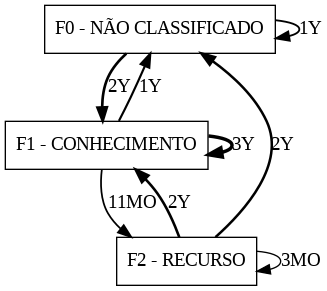

In [77]:
gviz = gerar_modelo_pm_from_db('TJPE', 'G1', 'GERAL', None)
dfg_visualization.view(gviz)

In [81]:
from flask import Flask
from flask import request
from flask import send_file

app = Flask(__name__)

@app.route('/download')
def downloadFile ():
    #For windows you need to use drive name [ex: F:/Example.pdf]
    path = "/Examples.pdf"
    return send_file(path, as_attachment=True)

@app.route("/testeflask")
def teste():
    param1 = request.args.get('teste')
    response = "Enviou param1 = " + param1

    return response

app.run(host='0.0.0.0', port='8080')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://0.0.0.0:8080/ (Press CTRL+C to quit)


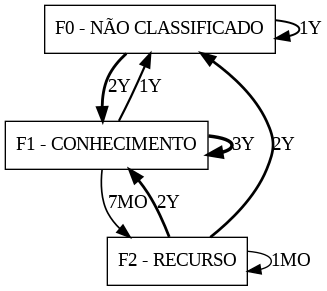

In [61]:
df_logeventos = spark.sql(
    "SELECT npu, fase, to_timestamp(mov_dtmov, 'yyyy-MM-dd HH:mm:ss') as dtmov " + 
    "FROM temp_proc_movimentos " + 
    "WHERE fase IS NOT NULL " + 
    "AND natureza = 'GERAL' " + 
    "ORDER BY mov_dtmov ASC"
)

logMovimentosDfPD = df_logeventos.toPandas()
dataframe = pm4py.format_dataframe(logMovimentosDfPD, case_id='npu', activity_key='fase', timestamp_key='dtmov')
eventLog = pm4py.convert_to_event_log(dataframe)

dfg = dfg_discovery.apply(eventLog, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)


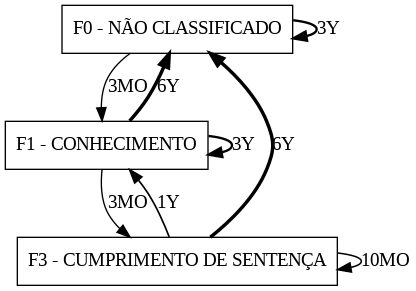

In [62]:
df_logeventos = spark.sql(
    "SELECT npu, fase, to_timestamp(mov_dtmov, 'yyyy-MM-dd HH:mm:ss') as dtmov " + 
    "FROM temp_proc_movimentos " + 
    "WHERE fase IS NOT NULL " + 
    "AND natureza = 'CRIMINAL' " + 
    "ORDER BY mov_dtmov ASC"
)

logMovimentosDfPD = df_logeventos.toPandas()
dataframe = pm4py.format_dataframe(logMovimentosDfPD, case_id='npu', activity_key='fase', timestamp_key='dtmov')
eventLog = pm4py.convert_to_event_log(dataframe)

dfg = dfg_discovery.apply(eventLog, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)


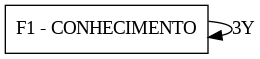

In [63]:
df_logeventos = spark.sql(
    "SELECT npu, fase, to_timestamp(mov_dtmov, 'yyyy-MM-dd HH:mm:ss') as dtmov " + 
    "FROM temp_proc_movimentos " + 
    "WHERE fase IS NOT NULL " + 
    "AND natureza = 'CIVEL' " + 
    "ORDER BY mov_dtmov ASC"
)

logMovimentosDfPD = df_logeventos.toPandas()
dataframe = pm4py.format_dataframe(logMovimentosDfPD, case_id='npu', activity_key='fase', timestamp_key='dtmov')
eventLog = pm4py.convert_to_event_log(dataframe)

dfg = dfg_discovery.apply(eventLog, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)


In [109]:
df_qry_test = spark.sql(
    "SELECT DISTINCT fase " + 
    "FROM proc_movimentos_join " + 
    "WHERE fase IS NOT NULL " + 
    "AND natureza = 'CIVEL' "
)

df_qry_test.show()

+-----------------+
|             fase|
+-----------------+
|F1 - CONHECIMENTO|
+-----------------+



In [64]:
# testando o carregamento de um arquivo com o schema
df_test = spark.read.schema(schema).json("./base/justica_estadual/processos-tjap/processos-tjap_2.json")
# Cria uma view temporaria para o dataframe
df_test.createOrReplaceTempView("test")

# Query para formato em CSV
df_qry_test = spark.sql(
    "SELECT DISTINCT " + 
    
    "dadosBasicos.numero, " +
    "dadosBasicos.classeProcessual, " +
    "to_timestamp(exp_movimento.movimento.dataHora, 'yyyyMMddHHmmss') as movimento_dataHora, "
    "exp_movimento.movimento.movimentoNacional.codigoNacional as movimentoNacional_codigoNacional "

    "FROM test " + 
    "LATERAL VIEW explode(movimento) exp_movimento as movimento " + 
    "WHERE dadosBasicos.dataAjuizamento >= 946684800000 AND " + 
    "exp_movimento.movimento.movimentoNacional.codigoNacional NOT IN(581, 85, 12270, 12271) " +
    "AND size(test.movimento) > 0 AND " + 
    "(test.movimento[0].movimentoNacional.codigoNacional IN (26, 12474) " +
    "AND test.movimento[size(test.movimento) -1].movimentoNacional.codigoNacional IN (22, 246)) " +
    "ORDER BY movimento_dataHora ASC"
)

df_qry_test = df_qry_test.join( \
    df_qry_movimentos, df_qry_test["movimentoNacional_codigoNacional"] == df_qry_movimentos["cod"], "inner")

df_qry_test.createOrReplaceTempView("test_eventlog")

df_qry_test = spark.sql(
    "SELECT numero, fase, movimento_dataHora " + 
    "FROM test_eventlog " + 
    "WHERE fase IS NOT NULL " + 
    "AND natureza = 'CRIMINAL' " + 
    "ORDER BY movimento_dataHora ASC"
)

df_qry_test.show()

+--------------------+--------------------+-------------------+
|              numero|                fase| movimento_dataHora|
+--------------------+--------------------+-------------------+
|00005526220098030010|F3 - CUMPRIMENTO ...|2010-06-07 17:33:50|
|00009931420078030010|F3 - CUMPRIMENTO ...|2010-10-05 15:46:21|
|00099489020098030001|F3 - CUMPRIMENTO ...|2011-03-03 09:54:08|
|00274001620098030001|F3 - CUMPRIMENTO ...|2011-04-01 10:02:35|
|00005702020088030010|F3 - CUMPRIMENTO ...|2011-04-12 17:46:50|
|00024905320088030002|F3 - CUMPRIMENTO ...|2011-04-28 12:53:51|
|00144882120088030001|F3 - CUMPRIMENTO ...|2011-05-17 09:56:29|
|00215204320098030001|F3 - CUMPRIMENTO ...|2011-05-17 12:53:29|
|00167305020088030001|F3 - CUMPRIMENTO ...|2011-05-18 09:21:34|
|00128704120088030001|F3 - CUMPRIMENTO ...|2011-06-14 12:20:03|
|00028716420088030001|F3 - CUMPRIMENTO ...|2011-06-20 12:47:21|
|00126929220088030001|F3 - CUMPRIMENTO ...|2012-01-13 10:25:44|
|00076918920098030002|F3 - CUMPRIMENTO .

In [65]:
logMovimentosDfPD = df_qry_test.toPandas()
dataframe = pm4py.format_dataframe(logMovimentosDfPD, case_id='numero', activity_key='fase', timestamp_key='movimento_dataHora')
eventLog = pm4py.convert_to_event_log(dataframe)

In [58]:
for case_index, case in enumerate(eventLog):
    print("\n case index: %d  case id: %s" % (case_index, case.attributes["concept:name"]))
    for event_index, event in enumerate(case):
        print("event index: %d  event activity: %s" % (event_index, event["concept:name"]))


 case index: 0  case id: 00000382120098030007
event index: 0  event activity: 51
event index: 1  event activity: 26
event index: 2  event activity: 60
event index: 3  event activity: 1051
event index: 4  event activity: 51
event index: 5  event activity: 60
event index: 6  event activity: 51
event index: 7  event activity: 12164
event index: 8  event activity: 51
event index: 9  event activity: 1051
event index: 10  event activity: 12164
event index: 11  event activity: 60
event index: 12  event activity: 51
event index: 13  event activity: 12164
event index: 14  event activity: 135
event index: 15  event activity: 123
event index: 16  event activity: 132
event index: 17  event activity: 311
event index: 18  event activity: 60
event index: 19  event activity: 60
event index: 20  event activity: 1061
event index: 21  event activity: 92
event index: 22  event activity: 123
event index: 23  event activity: 132
event index: 24  event activity: 51
event index: 25  event activity: 12164
eve

event index: 147  event activity: 970
event index: 148  event activity: 11010
event index: 149  event activity: 51
event index: 150  event activity: 11010
event index: 151  event activity: 51
event index: 152  event activity: 11010
event index: 153  event activity: 1061
event index: 154  event activity: 92
event index: 155  event activity: 51
event index: 156  event activity: 11010
event index: 157  event activity: 51
event index: 158  event activity: 377
event index: 159  event activity: 1061
event index: 160  event activity: 92
event index: 161  event activity: 10966
event index: 162  event activity: 12291
event index: 163  event activity: 1051
event index: 164  event activity: 1061
event index: 165  event activity: 92
event index: 166  event activity: 51
event index: 167  event activity: 11382
event index: 168  event activity: 1061
event index: 169  event activity: 92
event index: 170  event activity: 11383
event index: 171  event activity: 1061
event index: 172  event activity: 92


event index: 3  event activity: 51
event index: 4  event activity: 92
event index: 5  event activity: 51
event index: 6  event activity: 60
event index: 7  event activity: 51
event index: 8  event activity: 11383
event index: 9  event activity: 1061
event index: 10  event activity: 92
event index: 11  event activity: 493
event index: 12  event activity: 60
event index: 13  event activity: 132
event index: 14  event activity: 51
event index: 15  event activity: 51
event index: 16  event activity: 12164
event index: 17  event activity: 60
event index: 18  event activity: 12164
event index: 19  event activity: 11383
event index: 20  event activity: 1061
event index: 21  event activity: 92
event index: 22  event activity: 493
event index: 23  event activity: 132
event index: 24  event activity: 51
event index: 25  event activity: 12164
event index: 26  event activity: 60
event index: 27  event activity: 11383
event index: 28  event activity: 1061
event index: 29  event activity: 92
event i

event index: 14  event activity: 12164
event index: 15  event activity: 60
event index: 16  event activity: 12164
event index: 17  event activity: 51
event index: 18  event activity: 12164
event index: 19  event activity: 60
event index: 20  event activity: 60
event index: 21  event activity: 60
event index: 22  event activity: 123
event index: 23  event activity: 132
event index: 24  event activity: 51
event index: 25  event activity: 12164
event index: 26  event activity: 1051
event index: 27  event activity: 51
event index: 28  event activity: 12164
event index: 29  event activity: 60
event index: 30  event activity: 60
event index: 31  event activity: 60
event index: 32  event activity: 60
event index: 33  event activity: 51
event index: 34  event activity: 12164
event index: 35  event activity: 60
event index: 36  event activity: 123
event index: 37  event activity: 132
event index: 38  event activity: 51
event index: 39  event activity: 12164
event index: 40  event activity: 60
e

event index: 17  event activity: 493
event index: 18  event activity: 132
event index: 19  event activity: 51
event index: 20  event activity: 1061
event index: 21  event activity: 92
event index: 22  event activity: 493
event index: 23  event activity: 132
event index: 24  event activity: 123
event index: 25  event activity: 60
event index: 26  event activity: 123
event index: 27  event activity: 36
event index: 28  event activity: 51
event index: 29  event activity: 132
event index: 30  event activity: 12164
event index: 31  event activity: 123
event index: 32  event activity: 132
event index: 33  event activity: 123
event index: 34  event activity: 132
event index: 35  event activity: 51
event index: 36  event activity: 12164
event index: 37  event activity: 123
event index: 38  event activity: 132
event index: 39  event activity: 11383
event index: 40  event activity: 417
event index: 41  event activity: 1061
event index: 42  event activity: 92
event index: 43  event activity: 123


event index: 60  event activity: 980
event index: 61  event activity: 132
event index: 62  event activity: 51
event index: 63  event activity: 60
event index: 64  event activity: 60
event index: 65  event activity: 60
event index: 66  event activity: 51
event index: 67  event activity: 12164
event index: 68  event activity: 60
event index: 69  event activity: 51
event index: 70  event activity: 11010
event index: 71  event activity: 51
event index: 72  event activity: 11020
event index: 73  event activity: 60
event index: 74  event activity: 51
event index: 75  event activity: 11010
event index: 76  event activity: 60
event index: 77  event activity: 51
event index: 78  event activity: 11010
event index: 79  event activity: 60
event index: 80  event activity: 51
event index: 81  event activity: 51
event index: 82  event activity: 12164
event index: 83  event activity: 60
event index: 84  event activity: 51
event index: 85  event activity: 11010
event index: 86  event activity: 60
event

event index: 91  event activity: 11010
event index: 92  event activity: 245
event index: 93  event activity: 11010
event index: 94  event activity: 245
event index: 95  event activity: 11383
event index: 96  event activity: 123
event index: 97  event activity: 132
event index: 98  event activity: 51
event index: 99  event activity: 11010
event index: 100  event activity: 123
event index: 101  event activity: 132
event index: 102  event activity: 245
event index: 103  event activity: 941
event index: 104  event activity: 893
event index: 105  event activity: 12164
event index: 106  event activity: 493
event index: 107  event activity: 132
event index: 108  event activity: 246

 case index: 89  case id: 00024841220098030002
event index: 0  event activity: 26
event index: 1  event activity: 51
event index: 2  event activity: 60
event index: 3  event activity: 11383
event index: 4  event activity: 1061
event index: 5  event activity: 92
event index: 6  event activity: 493
event index: 7  e

event index: 53  event activity: 11010
event index: 54  event activity: 60
event index: 55  event activity: 12268
event index: 56  event activity: 493
event index: 57  event activity: 132
event index: 58  event activity: 60
event index: 59  event activity: 493
event index: 60  event activity: 132
event index: 61  event activity: 51
event index: 62  event activity: 788
event index: 63  event activity: 60
event index: 64  event activity: 12268
event index: 65  event activity: 493
event index: 66  event activity: 60
event index: 67  event activity: 132
event index: 68  event activity: 493
event index: 69  event activity: 60
event index: 70  event activity: 132
event index: 71  event activity: 51
event index: 72  event activity: 11010
event index: 73  event activity: 60
event index: 74  event activity: 60
event index: 75  event activity: 51
event index: 76  event activity: 12164
event index: 77  event activity: 60
event index: 78  event activity: 51
event index: 79  event activity: 11010
e

event index: 15  event activity: 493
event index: 16  event activity: 493
event index: 17  event activity: 132
event index: 18  event activity: 493
event index: 19  event activity: 493
event index: 20  event activity: 132
event index: 21  event activity: 60
event index: 22  event activity: 60
event index: 23  event activity: 60
event index: 24  event activity: 60
event index: 25  event activity: 60
event index: 26  event activity: 60
event index: 27  event activity: 60
event index: 28  event activity: 60
event index: 29  event activity: 493
event index: 30  event activity: 493
event index: 31  event activity: 132
event index: 32  event activity: 60
event index: 33  event activity: 11383
event index: 34  event activity: 60
event index: 35  event activity: 493
event index: 36  event activity: 132
event index: 37  event activity: 51
event index: 38  event activity: 12164
event index: 39  event activity: 60
event index: 40  event activity: 51
event index: 41  event activity: 12164
event in

event index: 38  event activity: 493
event index: 39  event activity: 132
event index: 40  event activity: 51
event index: 41  event activity: 12164
event index: 42  event activity: 60
event index: 43  event activity: 60
event index: 44  event activity: 11383
event index: 45  event activity: 493
event index: 46  event activity: 60
event index: 47  event activity: 132
event index: 48  event activity: 493
event index: 49  event activity: 132
event index: 50  event activity: 11383
event index: 51  event activity: 493
event index: 52  event activity: 132
event index: 53  event activity: 1051
event index: 54  event activity: 11383
event index: 55  event activity: 493
event index: 56  event activity: 132
event index: 57  event activity: 51
event index: 58  event activity: 11010
event index: 59  event activity: 493
event index: 60  event activity: 132
event index: 61  event activity: 51
event index: 62  event activity: 11010
event index: 63  event activity: 60
event index: 64  event activity:

event index: 81  event activity: 132
event index: 82  event activity: 51
event index: 83  event activity: 11010
event index: 84  event activity: 60
event index: 85  event activity: 11383
event index: 86  event activity: 60
event index: 87  event activity: 11383
event index: 88  event activity: 493
event index: 89  event activity: 132
event index: 90  event activity: 493
event index: 91  event activity: 132
event index: 92  event activity: 493
event index: 93  event activity: 132
event index: 94  event activity: 493
event index: 95  event activity: 132
event index: 96  event activity: 1051
event index: 97  event activity: 493
event index: 98  event activity: 132
event index: 99  event activity: 493
event index: 100  event activity: 132
event index: 101  event activity: 1051
event index: 102  event activity: 11383
event index: 103  event activity: 11383
event index: 104  event activity: 493
event index: 105  event activity: 132
event index: 106  event activity: 51
event index: 107  event

event index: 138  event activity: 11010
event index: 139  event activity: 493
event index: 140  event activity: 51
event index: 141  event activity: 132
event index: 142  event activity: 12164
event index: 143  event activity: 51
event index: 144  event activity: 12164
event index: 145  event activity: 60
event index: 146  event activity: 246

 case index: 206  case id: 00079326320098030002
event index: 0  event activity: 26
event index: 1  event activity: 51
event index: 2  event activity: 12164
event index: 3  event activity: 60
event index: 4  event activity: 11383
event index: 5  event activity: 60
event index: 6  event activity: 51
event index: 7  event activity: 12164
event index: 8  event activity: 60
event index: 9  event activity: 11383
event index: 10  event activity: 60
event index: 11  event activity: 493
event index: 12  event activity: 132
event index: 13  event activity: 51
event index: 14  event activity: 12164
event index: 15  event activity: 60
event index: 16  event 

event index: 78  event activity: 190
event index: 79  event activity: 60
event index: 80  event activity: 493
event index: 81  event activity: 132
event index: 82  event activity: 51
event index: 83  event activity: 11010
event index: 84  event activity: 11010
event index: 85  event activity: 11383
event index: 86  event activity: 60
event index: 87  event activity: 60
event index: 88  event activity: 493
event index: 89  event activity: 132
event index: 90  event activity: 51
event index: 91  event activity: 11010
event index: 92  event activity: 11383
event index: 93  event activity: 60
event index: 94  event activity: 51
event index: 95  event activity: 11010
event index: 96  event activity: 493
event index: 97  event activity: 132
event index: 98  event activity: 51
event index: 99  event activity: 11010
event index: 100  event activity: 11383
event index: 101  event activity: 60
event index: 102  event activity: 493
event index: 103  event activity: 51
event index: 104  event acti

event index: 115  event activity: 1051
event index: 116  event activity: 11383
event index: 117  event activity: 60
event index: 118  event activity: 493
event index: 119  event activity: 132
event index: 120  event activity: 51
event index: 121  event activity: 11010
event index: 122  event activity: 1061
event index: 123  event activity: 92
event index: 124  event activity: 51
event index: 125  event activity: 11010
event index: 126  event activity: 1061
event index: 127  event activity: 92
event index: 128  event activity: 493
event index: 129  event activity: 132
event index: 130  event activity: 51
event index: 131  event activity: 196
event index: 132  event activity: 1061
event index: 133  event activity: 92
event index: 134  event activity: 848
event index: 135  event activity: 246
event index: 136  event activity: 893
event index: 137  event activity: 246

 case index: 248  case id: 00117208820098030001
event index: 0  event activity: 26
event index: 1  event activity: 51
even

event index: 152  event activity: 246

 case index: 269  case id: 00127681920088030001
event index: 0  event activity: 26
event index: 1  event activity: 51
event index: 2  event activity: 60
event index: 3  event activity: 11383
event index: 4  event activity: 92
event index: 5  event activity: 11383
event index: 6  event activity: 51
event index: 7  event activity: 12164
event index: 8  event activity: 1061
event index: 9  event activity: 11383
event index: 10  event activity: 60
event index: 11  event activity: 11383
event index: 12  event activity: 1061
event index: 13  event activity: 11383
event index: 14  event activity: 1061
event index: 15  event activity: 92
event index: 16  event activity: 1051
event index: 17  event activity: 11383
event index: 18  event activity: 1061
event index: 19  event activity: 92
event index: 20  event activity: 51
event index: 21  event activity: 12164
event index: 22  event activity: 1061
event index: 23  event activity: 92
event index: 24  event 

event index: 32  event activity: 60
event index: 33  event activity: 493
event index: 34  event activity: 132
event index: 35  event activity: 51
event index: 36  event activity: 12164
event index: 37  event activity: 60
event index: 38  event activity: 11383
event index: 39  event activity: 60
event index: 40  event activity: 11383
event index: 41  event activity: 60
event index: 42  event activity: 493
event index: 43  event activity: 132
event index: 44  event activity: 51
event index: 45  event activity: 11010
event index: 46  event activity: 60
event index: 47  event activity: 11383
event index: 48  event activity: 60
event index: 49  event activity: 493
event index: 50  event activity: 132
event index: 51  event activity: 51
event index: 52  event activity: 12164
event index: 53  event activity: 11383
event index: 54  event activity: 60
event index: 55  event activity: 493
event index: 56  event activity: 132
event index: 57  event activity: 51
event index: 58  event activity: 12

event index: 110  event activity: 132
event index: 111  event activity: 51
event index: 112  event activity: 11010
event index: 113  event activity: 11383
event index: 114  event activity: 1061
event index: 115  event activity: 92
event index: 116  event activity: 493
event index: 117  event activity: 132
event index: 118  event activity: 51
event index: 119  event activity: 11010
event index: 120  event activity: 1061
event index: 121  event activity: 92
event index: 122  event activity: 493
event index: 123  event activity: 132
event index: 124  event activity: 51
event index: 125  event activity: 11010
event index: 126  event activity: 1061
event index: 127  event activity: 92
event index: 128  event activity: 60
event index: 129  event activity: 60
event index: 130  event activity: 51
event index: 131  event activity: 11010
event index: 132  event activity: 1061
event index: 133  event activity: 92
event index: 134  event activity: 60
event index: 135  event activity: 1061
event in

event index: 80  event activity: 60
event index: 81  event activity: 11383
event index: 82  event activity: 1061
event index: 83  event activity: 92
event index: 84  event activity: 1051
event index: 85  event activity: 11383
event index: 86  event activity: 1061
event index: 87  event activity: 92
event index: 88  event activity: 1051
event index: 89  event activity: 11383
event index: 90  event activity: 60
event index: 91  event activity: 51
event index: 92  event activity: 1051
event index: 93  event activity: 471
event index: 94  event activity: 1061
event index: 95  event activity: 92
event index: 96  event activity: 848
event index: 97  event activity: 123
event index: 98  event activity: 979
event index: 99  event activity: 980
event index: 100  event activity: 132
event index: 101  event activity: 60
event index: 102  event activity: 1051
event index: 103  event activity: 11383
event index: 104  event activity: 60
event index: 105  event activity: 60
event index: 106  event ac

event index: 74  event activity: 60
event index: 75  event activity: 60
event index: 76  event activity: 11383
event index: 77  event activity: 60
event index: 78  event activity: 493
event index: 79  event activity: 132
event index: 80  event activity: 51
event index: 81  event activity: 11010
event index: 82  event activity: 51
event index: 83  event activity: 11010
event index: 84  event activity: 1061
event index: 85  event activity: 92
event index: 86  event activity: 1051
event index: 87  event activity: 60
event index: 88  event activity: 493
event index: 89  event activity: 132
event index: 90  event activity: 51
event index: 91  event activity: 11382
event index: 92  event activity: 11383
event index: 93  event activity: 60
event index: 94  event activity: 493
event index: 95  event activity: 132
event index: 96  event activity: 11383
event index: 97  event activity: 1051
event index: 98  event activity: 11383
event index: 99  event activity: 60
event index: 100  event activit

event index: 89  event activity: 123
event index: 90  event activity: 132
event index: 91  event activity: 123
event index: 92  event activity: 51
event index: 93  event activity: 132
event index: 94  event activity: 239
event index: 95  event activity: 123
event index: 96  event activity: 132
event index: 97  event activity: 1061
event index: 98  event activity: 92
event index: 99  event activity: 1051
event index: 100  event activity: 123
event index: 101  event activity: 132
event index: 102  event activity: 51
event index: 103  event activity: 11010
event index: 104  event activity: 123
event index: 105  event activity: 132
event index: 106  event activity: 1061
event index: 107  event activity: 92
event index: 108  event activity: 493
event index: 109  event activity: 132
event index: 110  event activity: 123
event index: 111  event activity: 51
event index: 112  event activity: 132
event index: 113  event activity: 432
event index: 114  event activity: 123
event index: 115  event

event index: 212  event activity: 51
event index: 213  event activity: 12164
event index: 214  event activity: 60
event index: 215  event activity: 1051
event index: 216  event activity: 11383
event index: 217  event activity: 12265
event index: 218  event activity: 1051
event index: 219  event activity: 11383
event index: 220  event activity: 12265
event index: 221  event activity: 51
event index: 222  event activity: 12164
event index: 223  event activity: 12265
event index: 224  event activity: 51
event index: 225  event activity: 12164
event index: 226  event activity: 60
event index: 227  event activity: 1051
event index: 228  event activity: 12291
event index: 229  event activity: 51
event index: 230  event activity: 11383
event index: 231  event activity: 12265
event index: 232  event activity: 60
event index: 233  event activity: 60
event index: 234  event activity: 60
event index: 235  event activity: 1061
event index: 236  event activity: 92
event index: 237  event activity: 

event index: 82  event activity: 1051
event index: 83  event activity: 123
event index: 84  event activity: 51
event index: 85  event activity: 132
event index: 86  event activity: 430
event index: 87  event activity: 123
event index: 88  event activity: 132
event index: 89  event activity: 1061
event index: 90  event activity: 92
event index: 91  event activity: 1051
event index: 92  event activity: 123
event index: 93  event activity: 51
event index: 94  event activity: 132
event index: 95  event activity: 11010
event index: 96  event activity: 123
event index: 97  event activity: 132
event index: 98  event activity: 123
event index: 99  event activity: 132
event index: 100  event activity: 51
event index: 101  event activity: 123
event index: 102  event activity: 51
event index: 103  event activity: 132
event index: 104  event activity: 11010
event index: 105  event activity: 123
event index: 106  event activity: 132
event index: 107  event activity: 848
event index: 108  event acti

event index: 181  event activity: 51
event index: 182  event activity: 1051
event index: 183  event activity: 11010
event index: 184  event activity: 60
event index: 185  event activity: 60
event index: 186  event activity: 246

 case index: 442  case id: 00292958020078030001
event index: 0  event activity: 26
event index: 1  event activity: 51
event index: 2  event activity: 970
event index: 3  event activity: 60
event index: 4  event activity: 92
event index: 5  event activity: 970
event index: 6  event activity: 193
event index: 7  event activity: 848
event index: 8  event activity: 51
event index: 9  event activity: 92
event index: 10  event activity: 493
event index: 11  event activity: 51
event index: 12  event activity: 132
event index: 13  event activity: 493
event index: 14  event activity: 51
event index: 15  event activity: 132
event index: 16  event activity: 51
event index: 17  event activity: 135
event index: 18  event activity: 60
event index: 19  event activity: 51
even

event index: 51  event activity: 92
event index: 52  event activity: 1051
event index: 53  event activity: 11383
event index: 54  event activity: 1061
event index: 55  event activity: 92
event index: 56  event activity: 1051
event index: 57  event activity: 493
event index: 58  event activity: 132
event index: 59  event activity: 51
event index: 60  event activity: 12164
event index: 61  event activity: 11383
event index: 62  event activity: 1061
event index: 63  event activity: 92
event index: 64  event activity: 493
event index: 65  event activity: 60
event index: 66  event activity: 60
event index: 67  event activity: 132
event index: 68  event activity: 51
event index: 69  event activity: 12164
event index: 70  event activity: 60
event index: 71  event activity: 60
event index: 72  event activity: 51
event index: 73  event activity: 11010
event index: 74  event activity: 1061
event index: 75  event activity: 92
event index: 76  event activity: 1051
event index: 77  event activity: 

event index: 65  event activity: 12164
event index: 66  event activity: 1061
event index: 67  event activity: 92
event index: 68  event activity: 493
event index: 69  event activity: 132
event index: 70  event activity: 51
event index: 71  event activity: 12164
event index: 72  event activity: 60
event index: 73  event activity: 135
event index: 74  event activity: 493
event index: 75  event activity: 132
event index: 76  event activity: 493
event index: 77  event activity: 132
event index: 78  event activity: 51
event index: 79  event activity: 12164
event index: 80  event activity: 137
event index: 81  event activity: 1061
event index: 82  event activity: 92
event index: 83  event activity: 493
event index: 84  event activity: 132
event index: 85  event activity: 51
event index: 86  event activity: 12164
event index: 87  event activity: 60
event index: 88  event activity: 1051
event index: 89  event activity: 51
event index: 90  event activity: 12164
event index: 91  event activity: 

event index: 102  event activity: 1051
event index: 103  event activity: 51
event index: 104  event activity: 11010
event index: 105  event activity: 1061
event index: 106  event activity: 92
event index: 107  event activity: 493
event index: 108  event activity: 60
event index: 109  event activity: 132
event index: 110  event activity: 51
event index: 111  event activity: 11010
event index: 112  event activity: 1061
event index: 113  event activity: 92
event index: 114  event activity: 1061
event index: 115  event activity: 92
event index: 116  event activity: 1051
event index: 117  event activity: 51
event index: 118  event activity: 11010
event index: 119  event activity: 1061
event index: 120  event activity: 92
event index: 121  event activity: 51
event index: 122  event activity: 11010
event index: 123  event activity: 60
event index: 124  event activity: 11383
event index: 125  event activity: 1061
event index: 126  event activity: 92
event index: 127  event activity: 1061
event

event index: 124  event activity: 132
event index: 125  event activity: 11383
event index: 126  event activity: 417
event index: 127  event activity: 1061
event index: 128  event activity: 92
event index: 129  event activity: 123
event index: 130  event activity: 132
event index: 131  event activity: 51
event index: 132  event activity: 11010
event index: 133  event activity: 123
event index: 134  event activity: 132
event index: 135  event activity: 123
event index: 136  event activity: 132
event index: 137  event activity: 51
event index: 138  event activity: 123
event index: 139  event activity: 132
event index: 140  event activity: 123
event index: 141  event activity: 51
event index: 142  event activity: 132
event index: 143  event activity: 238
event index: 144  event activity: 123
event index: 145  event activity: 132
event index: 146  event activity: 1061
event index: 147  event activity: 92
event index: 148  event activity: 123
event index: 149  event activity: 51
event index:

event index: 122  event activity: 11383
event index: 123  event activity: 1061
event index: 124  event activity: 92
event index: 125  event activity: 1051
event index: 126  event activity: 11383
event index: 127  event activity: 1061
event index: 128  event activity: 92
event index: 129  event activity: 1051
event index: 130  event activity: 11383
event index: 131  event activity: 1061
event index: 132  event activity: 92
event index: 133  event activity: 51
event index: 134  event activity: 11010
event index: 135  event activity: 11383
event index: 136  event activity: 1061
event index: 137  event activity: 92
event index: 138  event activity: 51
event index: 139  event activity: 11010
event index: 140  event activity: 11383
event index: 141  event activity: 12265
event index: 142  event activity: 51
event index: 143  event activity: 11010
event index: 144  event activity: 11383
event index: 145  event activity: 12265
event index: 146  event activity: 60
event index: 147  event activi

event index: 46  event activity: 1051
event index: 47  event activity: 11383
event index: 48  event activity: 1061
event index: 49  event activity: 92
event index: 50  event activity: 11383
event index: 51  event activity: 1061
event index: 52  event activity: 92
event index: 53  event activity: 1051
event index: 54  event activity: 11383
event index: 55  event activity: 1061
event index: 56  event activity: 92
event index: 57  event activity: 51
event index: 58  event activity: 11010
event index: 59  event activity: 11383
event index: 60  event activity: 1061
event index: 61  event activity: 92
event index: 62  event activity: 51
event index: 63  event activity: 11010
event index: 64  event activity: 1061
event index: 65  event activity: 92
event index: 66  event activity: 123
event index: 67  event activity: 132
event index: 68  event activity: 51
event index: 69  event activity: 11010
event index: 70  event activity: 970
event index: 71  event activity: 60
event index: 72  event act

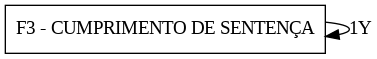

In [66]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

dfg = dfg_discovery.apply(eventLog, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)
